In [191]:
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn==0.24.0
# !pip install keras
# !pip install catboost
# !pip install tensorflow
# !pip install dill
# !pip install ipywidgets
# !pip install xgboost
# !pip install lightgbm
# !pip install pytorch-tabnet


In [2]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import catboost
import string
import tensorflow as tf
from matplotlib import pyplot as plt
from numpy import percentile, mean
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import f_regression, SelectKBest, mutual_info_regression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import RootMeanSquaredError

In [193]:
from tqdm import tqdm
import xgboost as xgb
import lightgbm
from lightgbm import LGBMRegressor
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import StackingRegressor

In [4]:
RANDOM_SEED = 42

In [5]:
def print_null_perc(df):
    """Функция рассчитывает долю Null значений в трейне и тесте. Вывод"""

    print('                Train          Test\n')

    train_shape = df[df['target'].isna() == False].shape[0]
    test_shape = df[df['target'].isna()].shape[0]

    for x in df.columns:
        train_null = df[df['target'].isna() == False][x].isna().sum()
        test_null = df[df['target'].isna()][x].isna().sum()
        print((x + ':' + ' '*15)[:15] + (str(round(train_null / train_shape * 
                                                   100, 4)) + ' '*15)[:15] + str(round(test_null / test_shape * 100, 4)))

In [6]:
def data_outlier(columns_list, df):
    """Функция определяет выбросы признаков и строит датафрейм"""

    data_out = pd.DataFrame(data={'name': [], 'count': [], 'min': [], 'mean': [], 'max': [],
                                  'low_range': [], 'upper_range': [], 'out_count': []
                                  })
    for column_name in columns_list:
        perc25 = percentile(df[column_name], 25)
        perc75 = percentile(df[column_name], 75)
        iqr = perc75 - perc25
        low_range = perc25 - 1.5 * iqr
        upper_range = perc75 + 1.5 * iqr
        out_count = df[column_name].apply(
            lambda x: None if x < low_range or x > upper_range else x).isna().sum()

        to_append = [column_name, df[column_name].count(), round(df[column_name].min(), 2),
                     round(df[column_name].mean(), 2), round(
                         df[column_name].max(), 2),
                     round(low_range, 2), round(upper_range, 2), out_count]
        data_out_length = len(data_out)
        data_out.loc[data_out_length] = to_append

    data_out = data_out.set_index('name')

    return data_out

In [7]:
def df_hist_plot(column_name, df_train):
    """Функция строит гистограмму для числового признака"""

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    new_series_log = np.log(df_train[column_name] + 1)

    ax[0].hist(df_train[column_name], rwidth=0.9, alpha=0.7, bins=15)
    ax[0].set_title(column_name)

    ax[1].hist(new_series_log, rwidth=0.9, alpha=0.7, bins=15)
    ax[1].set_title('log of ' + column_name)

    plt.show()

In [8]:
def mape(y_true, y_pred):
    """Функция для рассчета MAPE"""

    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
# читеам данные из файла в датафрейм

df = pd.read_csv("data_new.csv")

In [10]:
df.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [11]:
df.shape

(377185, 18)

In [12]:
df[df['target'].isna()].shape

(2481, 18)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

In [14]:
print("Percent NULL values\n")
round(df.isna().sum() / df.shape[0] * 100, 4)

Percent NULL values



status          10.5831
private pool    98.8915
propertyType     9.2085
street           0.0005
baths           28.1925
homeFacts        0.0000
fireplace       72.6620
city             0.0090
schools          0.0000
sqft            10.7579
zipcode          0.0000
beds            24.2009
state            0.0000
stories         39.9578
mls-id          93.3873
PrivatePool     89.3127
MlsId           17.7314
target           0.6578
dtype: float64

Вывод: Удаляем столбцы, где процент NULL значений больше 40%

In [15]:
df.drop(['private pool', 'fireplace', 'mls-id',
         'PrivatePool'], axis=1, inplace=True)

In [16]:
df.nunique()

status             159
propertyType      1280
street          337076
baths              229
homeFacts       321009
city              2026
schools         297365
sqft             25405
zipcode           4549
beds              1184
state               39
stories            348
MlsId           232944
target           43939
dtype: int64

# Обработка признаков

Status

In [17]:
df['status'] = df['status'].str.lower()

In [18]:
df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace(
    '[{}]'.format(string.digits), ' ').apply(lambda x: " ".join(str(x).split()))
df['status'] = df['status'].apply(
    lambda x: None if x is None else None if str(x) == 'nan' else x)
df['status'].value_counts(dropna=False)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/2816757384.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['status'] = df['status'].str.replace('[{}]'.format(string.punctuation), ' ').str.replace(


for sale                   199571
active                     105207
NaN                         39918
foreclosure                  6769
new construction             5475
                            ...  
conting accpt backups           1
conditional contract            1
pending take backups            1
pending w backup wanted         1
backup                          1
Name: status, Length: 104, dtype: int64

In [19]:
df['status'].nunique()

103

In [20]:
df['status'].isna().sum()

39918

PropertyType 

In [21]:
df['propertyType'].sample(10)

368417         Single Family
97481     single-family home
295962    Single Family Home
12030     single-family home
190469    single-family home
3358           Single Family
247211                   NaN
322942     Multi-Family Home
125606          multi-family
235701    single-family home
Name: propertyType, dtype: object

In [22]:
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(
    string.punctuation), ' ').apply(lambda x: " ".join(str(x).split()))
df['propertyType'] = df['propertyType'].str.replace(
    'one', '1').str.replace('two', '2')

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/1534699485.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace('[{}]'.format(


In [23]:
df['propertyType'].value_counts()[20:40]

contemporary modern           1010
apartment                      922
2 stories                      911
mfd mobile home                792
single detached                751
detached 2 story               638
2 story                        596
transitional                   560
cooperative                    535
florida                        530
bungalow                       442
farms ranches                  371
garden home                    305
cape cod                       281
2 stories traditional          280
spanish mediterranean          272
other style                    249
1 story traditional            238
other                          232
condo townhome traditional     225
Name: propertyType, dtype: int64

In [24]:
df['stories_dop'] = df['propertyType'].str.findall(
    r'[a-z0-9]+ story|[a-z0-9]+ stories').apply(lambda x: None if len(x) == 0 else x[-1])
df['stories_dop'].value_counts(dropna=False)

set_story = set(df['stories_dop'].dropna())
for y in set_story:
    df['propertyType'] = df['propertyType'].str.replace(y, '')

In [25]:
set_story = set(df['stories_dop'].dropna())
for y in set_story:
    df['propertyType'] = df['propertyType'].str.replace(y, '')

In [26]:
df['propertyType'] = df['propertyType'].str.replace('home', '')
df['propertyType'] = df['propertyType'].apply(lambda x: None if x == '' else
                                              None if str(x) == 'nan' else
                                              None if str(x) == 'None' else " ".join(str(x).split()))

In [27]:
df['propertyType'].nunique()

1112

In [28]:
df['propertyType'].value_counts(dropna=False)

single family                                               186803
condo                                                        42530
NaN                                                          38211
lot land                                                     20552
townhouse                                                    18401
                                                             ...  
single detached southwestern                                     1
other ranch                                                      1
traditional colonial federal                                     1
condo town french split level                                    1
bilevel converted dwelling loft with bedrooms condo unit         1
Name: propertyType, Length: 1113, dtype: int64

In [29]:
df['propertyType'] = df['propertyType'].str.replace(
    r'[0-9]+[a-z]+[0-9]+', '').str.strip()
df['propertyType'] = df['propertyType'].str.replace(
    r'\b[0-9]+\b', '').str.strip()
df['propertyType'] = df['propertyType'].str.replace(
    r'\b[a-z]{2}\b', '').str.strip()

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/566886396.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(
C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/566886396.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(
C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/566886396.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['propertyType'] = df['propertyType'].str.replace(


In [30]:
# Взять базовые значения

df['propertyType'] = df['propertyType'].apply(lambda x: None if x is None else
                                              None if str(x) == '' else
                                              " ".join(x.split()[:3]))

Street не обрабатываем, так как там получится слишком много уникальных значений

Baths

In [31]:
df['baths'] = df['baths'].apply(lambda x: None if x is np.nan else x)
df['baths'].value_counts(dropna=False)

NaN           106338
2 Baths        52466
3 Baths        35506
2              20452
2.0            16576
               ...  
4.75 Baths         1
5.25 Baths         1
41.0               1
1.8 Baths          1
44.0               1
Name: baths, Length: 230, dtype: int64

In [32]:
punct = '~—\-:'

df['baths'] = df['baths'].str.lower().str.replace(
    '[a-z]+\.?', '').str.replace(',', '.').str.replace('[{}]'.format(punct), ' ')
df['baths'] = df['baths'].apply(lambda x: None if str(x).strip() == '' else x)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/3419356739.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['baths'] = df['baths'].str.lower().str.replace(


In [33]:
df['baths'] = df['baths'].str.findall('[0-9]+\.?[0-9]*')
df['baths'] = df['baths'].apply(
    lambda x: None if x is None else x[0]).astype(float)

df['baths'].value_counts(dropna=False)

NaN      107838
2.0      103519
3.0       66683
4.0       26333
1.0       17787
          ...  
5.2           1
116.0         1
35.0          1
241.0         1
68.0          1
Name: baths, Length: 85, dtype: int64

City не обрабатываем, так как там получится слишком много уникальных значений

Sqft

In [34]:
df['sqft'].value_counts(dropna=False)

NaN                                        40577
0                                          11854
1,200 sqft                                   839
1,000 sqft                                   654
1,100 sqft                                   573
                                           ...  
9,914                                          1
Total interior livable area: 3,055 sqft        1
5,177                                          1
11620                                          1
Total interior livable area: 4,615 sqft        1
Name: sqft, Length: 25406, dtype: int64

In [35]:
df['sqft'] = df['sqft'].apply(lambda x: None if x is np.nan else
                              None if str(x) == '' else str(x))

In [36]:
df['sqft'] = df['sqft'].str.replace(',', '')
df['sqft'] = df['sqft'].str.findall('[0-9]+\.?[0-9]*')
df['sqft'] = df['sqft'].apply(lambda x: None if x is None else
                              None if len(x) == 0 else int(x[0]))

In [37]:
df['sqft'].value_counts(dropna=False)

NaN        41397
0.0        11854
1200.0      1426
1000.0      1027
1500.0      1014
           ...  
8074.0         1
13418.0        1
20816.0        1
11170.0        1
13870.0        1
Name: sqft, Length: 9897, dtype: int64

Zipcode

In [38]:
df['zipcode'].value_counts(dropna=False)

32137         2141
33131         1563
34747         1488
78245         1390
34759         1333
              ... 
27613-4237       1
43054            1
41630            1
27615-3709       1
64015            1
Name: zipcode, Length: 4549, dtype: int64

In [39]:
# Приведем все значения к 5-значному формату

df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else
                                                                None if x == '' else
                                                                ('0000' + str(x))[-5:])

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/4276070190.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['zipcode'] = df['zipcode'].str.replace('\-[0-9]*', '').apply(lambda x: None if x is None else


Beds

In [40]:
df['beds'] = df['beds'].apply(lambda x: None if x is np.nan else x).str.lower()

In [41]:
df['beds'].value_counts(dropna=False)

NaN            91282
3 beds         53459
4 beds         35418
3              31406
2 beds         26362
               ...  
8,023 sqft         1
10,193 sqft        1
8.93 acres         1
5,510 sqft         1
8,479 sqft         1
Name: beds, Length: 1185, dtype: int64

In [42]:
# Данные по sqft выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (
    df['beds'].str.contains('sqft')), ['sqft', 'beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (
    df['beds'].str.contains('sqft')), ['sqft', 'beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall(
    '[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('sqft')),
       'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna() == False) & (
    df['beds'].str.contains('sqft')), 'beds'] = None

In [43]:
# Данные по sqft в акрах выделим из столбца beds

index_sqft = df.loc[(df['sqft'].isna()) & (
    df['beds'].str.contains('acre')), ['sqft', 'beds']].index
new_sqft = df.loc[(df['sqft'].isna()) & (
    df['beds'].str.contains('acre')), ['sqft', 'beds']]
new_sqft['sqft'] = new_sqft['beds'].str.strip().str.replace(',', '.').str.findall(
    '[0-9]+\.*[0-9]*').apply(lambda x: None if len(x) == 0 else x[0]).astype(float)
new_sqft['sqft'] = (new_sqft['sqft'] * 43560).astype(int)

df.loc[(df['sqft'].isna()) & (df['beds'].str.contains('acre')),
       'sqft'] = new_sqft['sqft']
df.loc[(df['beds'].isna() == False) & (
    df['beds'].str.contains('acre')), 'beds'] = None

In [44]:
df['beds'] = df['beds'].str.replace(
    'bedrooms', 'beds').str.replace('bd', 'beds')
df['beds'] = df['beds'].str.replace('or more ', '').str.replace(
    '#', '').str.replace(r'[0-9]+[a-z]+', '')

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/1282382572.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['beds'] = df['beds'].str.replace('or more ', '').str.replace(


In [45]:
df.loc[(df['beds'].isna() == False) & (
    df['beds'].str.strip().str.contains('^[a-z,\-%@#_:;~ ]+$')), 'beds'] = None

In [46]:
# Данные по baths выделим из столбца beds

new_bath = df.loc[(df['baths'].isna()) & (df['beds'].str.contains('bath')), 'beds'].str.findall(
    '[0-9a-z ]+ bath').apply(lambda x: x[0].split()[0]).astype(float)
df.loc[new_bath.index, 'baths'] = new_bath

In [47]:
df['beds'].isna().sum()

# Уже на данном этапе слишком много пустых значений, удалим данный столбец

111391

State

In [48]:
df['state'].value_counts(dropna=False)

FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
NJ       436
ME       259
IA       242
KY        90
OK        49
MS        40
SC        28
MT         7
DE         5
Fl         1
BA         1
AL         1
OT         1
OS         1
Name: state, dtype: int64

Stories

In [49]:
df['stories_dop'] = df['stories_dop'].apply(
    lambda x: None if x is None else x.split()[0]).astype(float)
df['stories_dop'].value_counts(dropna=False)

NaN    369527
1.0      4440
2.0      3024
3.0       140
8.0        38
7.0        15
5.0         1
Name: stories_dop, dtype: int64

In [50]:
df['stories'] = df['stories'].str.lower()
df['stories'].value_counts(dropna=False)[:10]

NaN    150715
1.0     67454
2.0     55283
1       23086
2       18146
3.0     11275
0.0      7241
one      5758
0        4273
3        4228
Name: stories, dtype: int64

Замечание: Слишком много пустых значений, даже с учетом добвления stories_dop, удалим оба столбца

MlsId: удалим признак

In [51]:
df = df.drop('MlsId', axis=1)

HomeFacts

In [52]:
df['homeFacts'] = df['homeFacts'].apply(
    lambda x: eval(x)).apply(lambda x: list(x.values())[0])

In [53]:
list_columns = ['Year built', 'Remodeled year', 'Heating',
                'Cooling', 'Parking', 'lotsize', 'Price/sqft']

for column in enumerate(list_columns):
    df[column[1]] = None
    df[column[1]] = df['homeFacts'].apply(lambda x: None if x[column[0]].get(
        'factValue') == '' else x[column[0]].get('factValue'))

Year built

In [54]:
df['Year built'].value_counts(dropna=False)

NaN     62374
2019    32171
2006     8008
2005     7503
2007     7152
        ...  
1807        1
1809        1
1700        1
1823        1
1804        1
Name: Year built, Length: 230, dtype: int64

In [55]:
df.loc[df['Year built'].str.len() > 4, 'Year built'] = None
df.loc[df['Year built'].str.len() < 4, 'Year built'] = None

In [56]:
df['Year built'] = df['Year built'].apply(lambda x: None if x is None else
                                          None if 'No' in x else
                                          None if str(x) == 'nan' else
                                          None if str(x) == '' else int(x))

Remodeled year

In [57]:
df['Remodeled year'].value_counts(dropna=False)

NaN     226110
2006      5538
2005      4817
2007      4387
2008      3796
         ...  
1870         1
1845         1
1846         1
1111         1
1862         1
Name: Remodeled year, Length: 154, dtype: int64

Замечание: слишком много пропусков, удалим потом столбец

Heating

In [58]:
df['Heating'].value_counts(dropna=False)[:10]

# Слишком много пропусков и непоказательных данных, удалим потом столбец

NaN                 109332
Forced Air           82807
Forced air           51506
Other                29623
Electric             10211
Gas                   9296
No Data               8611
Central Air           7814
Central Electric      7112
Central               6247
Name: Heating, dtype: int64

Cooling

In [59]:
df['Cooling'].value_counts(dropna=False)

Central                                                                158754
NaN                                                                    123967
Central Air                                                             14384
No Data                                                                 10616
Has Cooling                                                              9730
                                                                        ...  
Central Gas, Propane, Zoned                                                 1
Other (See Remarks), Panel/Floor/Wall, Window Unit                          1
Multi Units, Zoned Cooling                                                  1
Central Air, g-Energy Star HVAC, Gas Hot Air/Furnace, Multizone A/C         1
Central A/C (Gas), Central Heat (Gas), Heat Pump                            1
Name: Cooling, Length: 1445, dtype: int64

Замечание: слишком много пропусков, удалим потом столбец

Parking

In [60]:
df['Parking'].value_counts(dropna=False)[:10]

NaN                         175420
Attached Garage              70752
2 spaces                     28063
1 space                      14252
No Data                      13334
Detached Garage              13201
Carport                       7743
3 spaces                      4724
Off Street                    3622
Carport, Attached Garage      3025
Name: Parking, dtype: int64

Замечание: слишком много пропусков и непоказательных данных, удалим потом столбец

lotsize sqft

In [61]:
df[['lotsize', 'sqft']].sample(5)

,lotsize,sqft
132292,11326,0.0
193514,—,1600.0
188154,"5,700 Sq. Ft.",2114.0
304019,0.88 Acres,4546.0
279211,5.89 acres,NaN


In [62]:
df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else
                                                                                       None if 'no' in x else
                                                                                       None if x == '' else x)

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/2125888368.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['lotsize'] = df['lotsize'].str.lower().str.replace(r'[\-,—]', '').str.strip().apply(lambda x: None if x is None else


In [63]:
# Заполним те значения признака sqft которые пустые из признака lotsize

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna() == False) & (
    df['lotsize'].str.contains('sq'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace(
    r'[a-z \.]', '').str.strip()
new_lot_size = new_lot_size.apply(lambda x: None if x is None else
                                  None if x is np.nan else
                                  None if x == '' else int(float(x)))
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

# acres
new_lot_size = df.loc[(df['sqft'].isna()) & (df['lotsize'].isna() == False) & (
    df['lotsize'].str.contains('acre'))]['lotsize']
new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()
new_lot_size = new_lot_size.apply(
    lambda x: None if x is None else float(x) * 43560).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/176344557.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  new_lot_size = new_lot_size.str.lower().str.replace(
C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/176344557.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  new_lot_size = new_lot_size.str.lower().str.replace('[a-z ]', '').str.strip()


In [64]:
df['sqft'].isna().sum()

11890

Price/sqft

In [65]:
df['Price/sqft'].sample(10)

28810               $313
52035               None
110603              None
46669          $576/sqft
242118         $194/sqft
196461         $140/sqft
50991     $453 / Sq. Ft.
144588              None
62889               $100
255578    $249 / Sq. Ft.
Name: Price/sqft, dtype: object

In [66]:
df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(
    r'[,/$a-z\. ]', '').str.strip().apply(lambda x: None if x is None else
                                          None if x == '' else int(x))

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/773651646.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Price/sqft'] = df['Price/sqft'].str.lower().str.replace(


Schools

In [67]:
df['schools'] = df['schools'].apply(lambda x: eval(x)[0])

In [68]:
list_keys = ['data', 'name', 'rating']
# name не будем брать

list_columns = ['Distance', 'Grades', 'rating']
# Grades не будем брать слишком запутано

df['Distance'] = df['schools'].apply(lambda x: None if x.get(
    'data').get('Distance') is None else x.get('data').get('Distance'))
df['rating'] = df['schools'].apply(
    lambda x: None if x.get('rating') is None else x.get('rating'))

In [69]:
df['Distance'] = df['Distance'].apply(
    lambda x: [float(y.replace('mi', '').strip()) for y in x])

In [70]:
df['Distance'] = df['Distance'].apply(lambda x: list(filter(None, x)))

In [71]:
df['Distance'].sample(10)

255112                          [1.52, 0.28, 1.66]
173462                    [0.31, 1.76, 0.56, 0.35]
30034                    [0.6, 3.3, 1.9, 2.3, 2.5]
75902                              [0.4, 4.3, 4.2]
287879    [0.8, 0.8, 1.0, 1.2, 2.5, 1.3, 0.9, 1.3]
273681                          [0.79, 0.32, 1.57]
114731                          [2.05, 0.66, 2.52]
322977                          [4.99, 6.29, 1.95]
73842                              [3.3, 2.0, 2.6]
257444                             [0.7, 3.1, 1.5]
Name: Distance, dtype: object

In [72]:
df['rating'] = df['rating'].apply(lambda x: [None if "NR" in str(y) else
                                             None if "None" in str(y) else
                                             None if "NA" in str(y) else
                                             None if str(y) == '' else
                                             int(str(y).split('/')[0]) if "/" in str(y) else
                                             int(y) for y in x])

In [73]:
df['rating'] = df['rating'].apply(lambda x: list(filter(None, x)))

In [74]:
df['rating'].sample(10)

207612                                            [9, 6, 4]
361141                                               [9, 9]
185670                                            [6, 3, 4]
309836                                        [5, 5, 2, 10]
332497                                            [9, 9, 9]
287278                                      [1, 1, 2, 3, 3]
118059                                    [5, 10, 10, 9, 2]
241632                                            [5, 7, 4]
70264                                             [3, 3, 2]
306594    [2, 1, 2, 6, 1, 2, 3, 2, 4, 1, 3, 3, 3, 2, 1, ...
Name: rating, dtype: object

Target

In [75]:
df['target'].value_counts(dropna=False)

NaN          2481
$225,000     1462
$275,000     1355
$250,000     1312
$350,000     1296
             ... 
$390,359        1
$458,900+       1
274,359         1
$273,490+       1
$171,306        1
Name: target, Length: 43940, dtype: int64

In [76]:
df['target'] = df['target'].apply(lambda x: None if x is np.nan else x)

In [77]:
punct = '$,+\-/'
df['target'] = df['target'].str.replace(
    '[a-z]', '').str.replace('[{}]'.format(punct), '').str.strip()

C:\Users\Timofey\AppData\Local\Temp/ipykernel_780/1342961650.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['target'] = df['target'].str.replace(


In [78]:
df['target'] = df['target'].apply(
    lambda x: None if x is None else int(x.split()[0]))

In [79]:
df['target'].value_counts(dropna=False)

NaN         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34233, dtype: int64

Target Price/sqft

In [80]:
# Заполним те значения признака sqft которые пустые из признака Price/sqft и признака target

new_lot_size = df.loc[(df['sqft'].isna()) & (df['target'].isna() == False) & (
    df['Price/sqft'].isna() == False)][['Price/sqft', 'target']]
new_lot_size['sqft'] = (new_lot_size['target'] /
                        new_lot_size['Price/sqft']).astype(int)
df.loc[new_lot_size.index, 'sqft'] = new_lot_size['sqft']

# Заполним те значения признака Price/sqft которые пустые из признака sqft и признака target

new_prsq = df.loc[(df['sqft'].isna() == False) & (
    df['target'].isna() == False) & (df['Price/sqft'].isna())][['sqft', 'target']]
new_prsq['Price/sqft'] = round(new_prsq['target'] / new_prsq['sqft'])
df.loc[new_prsq.index, 'Price/sqft'] = new_prsq['Price/sqft']

# Feature Engineering

In [81]:
df.sample(5)

,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,...,stories_dop,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,Distance,rating
256849,active,condo town rise,1001 Belleview St #701,NaN,"[{'factValue': '2007', 'factLabel': 'Year buil...",Dallas,"{'rating': ['2', '3', '1', '10'], 'data': {'Di...",1336.0,75215,None,...,NaN,2007.0,2007,None,"Central A/C (Electric), Central Heat (Electric)",None,None,269.0,"[1.4, 1.4, 1.8, 2.0]","[2, 3, 1, 10]"
308608,active,transitional,2915 Winding Waters Way,NaN,"[{'factValue': '2006', 'factLabel': 'Year buil...",Raleigh,"{'rating': ['6', '5', '5'], 'data': {'Distance...",1648.0,27614,None,...,NaN,2006.0,2006,None,None,None,1742 sq. ft.,137.0,"[1.7, 1.8, 1.9]","[6, 5, 5]"
92011,None,condo,11005 SW 1 St Miami # 105,1.0,"[{'factValue': '1968', 'factLabel': 'Year buil...",Miami,"{'rating': ['10/10', '5/10'], 'data': {'Distan...",827.0,33174,2,...,NaN,1968.0,None,No Data,Central,1 space,None,225.0,"[15.9, 4.1]","[10, 5]"
291175,None,single family,Buildable plan: Armstrong Verwood at Mercer Cr...,2.0,"[{'factValue': '2019', 'factLabel': 'Year buil...",Farmers Branch,"{'rating': ['2/10', '4/10', '5/10'], 'data': {...",2230.0,75234,3,...,NaN,2019.0,None,No Data,No Data,2 spaces,None,192.0,"[1.7, 2.7, 1.2]","[2, 4, 5]"
168664,for sale,single family,4460 Bollenbacher Ave,3.0,"[{'factValue': '1978', 'factLabel': 'Year buil...",Sacramento,"{'rating': ['2/10', '4/10', '3/10'], 'data': {...",1991.0,95838,4,...,NaN,1978.0,None,Forced air,Central,2 spaces,6534 sqft,176.0,"[0.4, 2.6, 2.2]","[2, 4, 3]"


In [82]:
# Доля Null значений в трейне и тесте

print_null_perc(df)

                Train          Test

status:        10.4768        26.6425
propertyType:  10.1611        7.2551
street:        0.0005         0.0
baths:         28.5164        39.5002
homeFacts:     0.0            0.0
city:          0.0091         0.0
schools:       0.0            0.0
sqft:          3.0437         5.1592
zipcode:       0.0005         0.0
beds:          29.5623        24.9899
state:         0.0            0.0
stories:       39.9766        37.1221
target:        0.0            100.0
stories_dop:   97.9565        99.9597
Year built:    16.8856        13.2608
Remodeled year:60.0124        50.0202
Heating:       28.9962        27.4889
Cooling:       32.8457        35.9936
Parking:       46.5744        36.4369
lotsize:       24.4324        19.6292
Price/sqft:    3.0437         85.8122
Distance:      0.0            0.0
rating:        0.0            0.0


In [83]:
# Удалим признаки street, city
df = df.drop(['street', 'city'], axis=1)

# Удалим признаки ненужные
df = df.drop(['homeFacts', 'schools', 'stories_dop', 'lotsize'], axis=1)

# # Удалим столбцы, в которых много пустых значений либо вообще, либо много пустых значений в тесте
df = df.drop(['stories', 'baths', 'beds', 'Remodeled year',
              'Heating', 'Cooling', 'Parking', 'Price/sqft'], axis=1)
df = df.drop(['status'], axis=1)

In [84]:
# Содаем новые признаки

df['dist_max'] = df['Distance'].apply(lambda x: None if x is None else
                                      None if len(x) == 0 else max(x))
df['dist_min'] = df['Distance'].apply(lambda x: None if x is None else
                                      None if len(x) == 0 else min(x))

In [85]:
df['rate_max'] = df['rating'].apply(lambda x: None if x is None else
                                    None if len(x) == 0 else max(x))
df['rate_min'] = df['rating'].apply(lambda x: None if x is None else
                                    None if len(x) == 0 else min(x))

In [86]:
# Удалим признаки ненужные

df = df.drop(['Distance', 'rating'], axis=1)

# Preproc null values

In [87]:
df_train = df[df['target'].isna() == False].copy()
df_test = df[df['target'].isna()].copy()
df_test['target'] = 0

In [88]:
df_train.head()

,propertyType,sqft,zipcode,state,target,Year built,dist_max,dist_min,rate_max,rate_min
0,single family,2900.0,28387,NC,418000.0,2019.0,12.60,2.70,7.0,4.0
1,single family,1947.0,99216,WA,310000.0,2019.0,1.65,1.01,4.0,4.0
2,single family,3000.0,90049,CA,2895000.0,1961.0,2.63,1.19,8.0,4.0
3,single family,6457.0,75205,TX,2395000.0,2006.0,1.05,0.10,10.0,9.0
4,lot land,10019.0,32908,FL,5000.0,NaN,5.96,3.03,5.0,4.0


In [89]:
df_train.isna().sum()

# Мало значений null удалим их

propertyType    38074
sqft            11405
zipcode             2
state               0
target              0
Year built      63271
dist_max         4258
dist_min         4258
rate_max         5117
rate_min         5117
dtype: int64

In [90]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 285190 entries, 0 to 377184
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   propertyType  285190 non-null  object 
 1   sqft          285190 non-null  float64
 2   zipcode       285190 non-null  object 
 3   state         285190 non-null  object 
 4   target        285190 non-null  float64
 5   Year built    285190 non-null  float64
 6   dist_max      285190 non-null  float64
 7   dist_min      285190 non-null  float64
 8   rate_max      285190 non-null  float64
 9   rate_min      285190 non-null  float64
dtypes: float64(7), object(3)
memory usage: 23.9+ MB


In [91]:
df_test.isna().sum()

# Мало нулевых значений, заполним их

propertyType    180
sqft            128
zipcode           0
state             0
target            0
Year built      329
dist_max         27
dist_min         27
rate_max         35
rate_min         35
dtype: int64

Заполнение null значение в тесте

<AxesSubplot:>

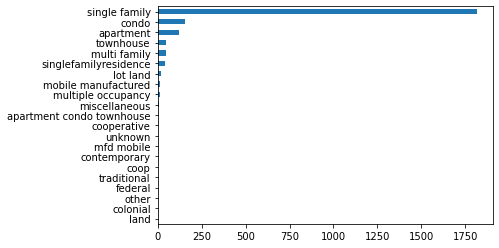

In [92]:
df_test['propertyType'].value_counts(ascending=True).plot.barh()

In [93]:
# Заменим null значения
df_test.loc[df_test['propertyType'].isna(), 'propertyType'] = 'other'

In [94]:
mean_sqft = round(df_test['sqft'].dropna().mean())

df_test.loc[df_test['sqft'].isna(), 'sqft'] = mean_sqft

In [95]:
mean_dist_max = round(df_test['dist_max'].dropna().mean())

df_test.loc[df_test['dist_max'].isna(), 'dist_max'] = mean_dist_max

In [96]:
mean_dist_min = round(df_test['dist_min'].dropna().mean())

df_test.loc[df_test['dist_min'].isna(), 'dist_min'] = mean_dist_min

In [97]:
mean_rate_max = round(df_test['rate_max'].dropna().mean())

df_test.loc[df_test['rate_max'].isna(), 'rate_max'] = mean_rate_max

In [98]:
mean_rate_min = round(df_test['rate_min'].dropna().mean())

df_test.loc[df_test['rate_min'].isna(), 'rate_min'] = mean_rate_min

In [99]:
year_mean = round(df_test['Year built'].dropna().mean())

df_test.loc[df_test['Year built'].isna(), 'Year built'] = year_mean

# Mатрица корреляции

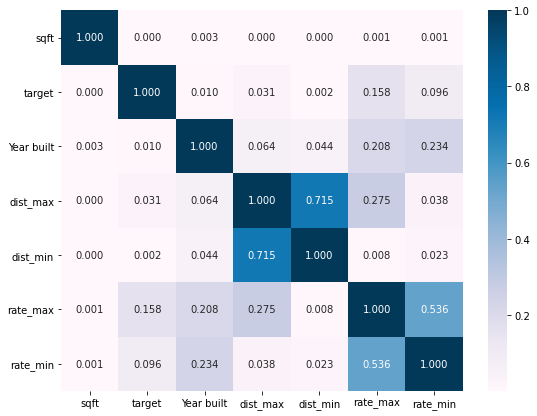

In [100]:
plt.figure(figsize=(9, 7))

sns.heatmap(df_train.corr().abs(), annot=True, fmt='.3f', cmap='PuBu')
plt.yticks(rotation=0)
plt.show()

In [101]:
# Очень сильная корреляция между dist_max и dist_min, возможно потом удалим

In [102]:
df.columns

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min'],
      dtype='object')

In [103]:
# Задаем типы переменных

categorical_features = ['propertyType', 'zipcode', 'state']
numerical_features = ['sqft', 'Year built',
                      'dist_max', 'dist_min', 'rate_max', 'rate_min']
value = ['target']

In [104]:
# Смотрим выбросы в трейне

data_out = data_outlier(numerical_features + value, df_train)
data_out

,count,min,mean,max,low_range,upper_range,out_count
name,,,,,,,
sqft,285190.0,0.00,11465.41,7.959794e+08,-773.50,4702.50,17206.0
Year built,285190.0,1057.00,1979.10,2.025000e+03,1879.50,2083.50,739.0
dist_max,285190.0,0.02,4.91,1.591090e+03,-3.50,10.10,32788.0
dist_min,285190.0,0.01,1.08,1.590380e+03,-0.95,2.49,22413.0
rate_max,285190.0,1.00,6.72,1.000000e+01,-1.00,15.00,0.0
rate_min,285190.0,1.00,3.66,1.000000e+01,-2.50,9.50,474.0
target,285190.0,1.00,652171.00,1.950000e+08,-374500.00,1183900.00,28982.0


# Рассмотрим числовые признаки по-отдельности

Target

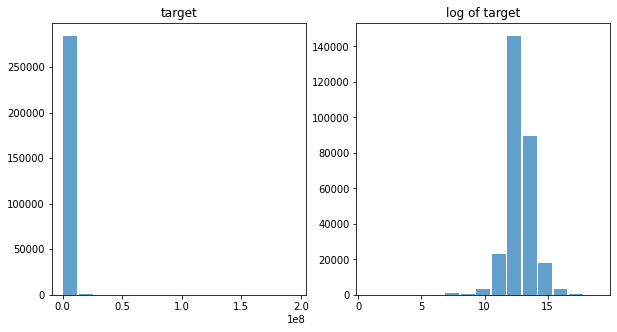

In [105]:
df_hist_plot('target', df_train)

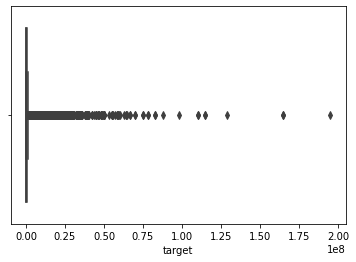

,count,min,mean,max,low_range,upper_range,out_count
target,285190.0,1.0,652171.0,195000000.0,-374500.0,1183900.0,28982.0


In [106]:
# График выбросов
sns.boxplot(x=df_train["target"])
plt.show()

# Выбросы
data_out.loc['target'].to_frame().T

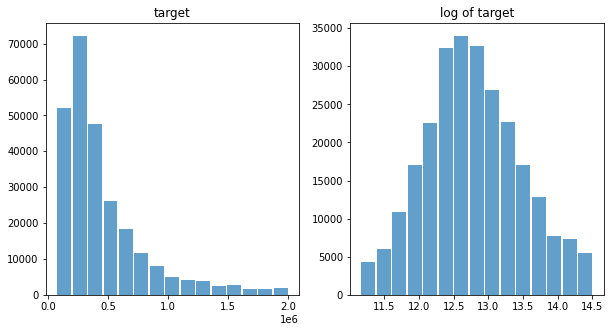

In [107]:
df_hist_plot('target', df_train[(df_train['target'] > 70_000) & (
    df_train['target'] < 2_000_000)])

In [108]:
df_train = df_train[(df_train['target'] > 70_000) &
                    (df_train['target'] < 2_000_000)]

In [109]:
df_train['target_log'] = np.log(df_train['target'] + 1)
df_test['target_log'] = 0

Sqft

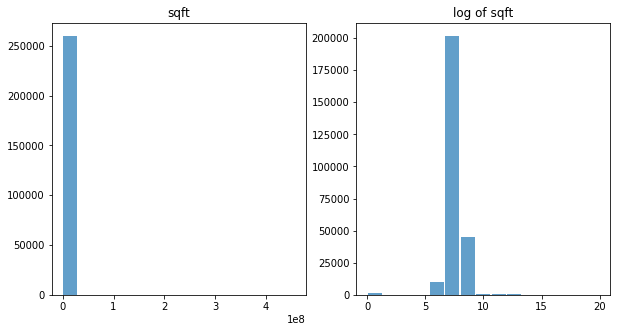

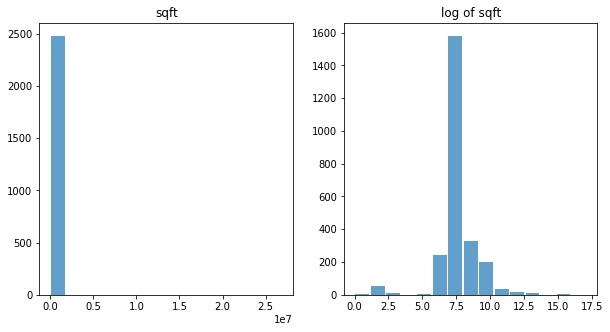

In [110]:
# sqft
df_hist_plot('sqft', df_train)
df_hist_plot('sqft', df_test)

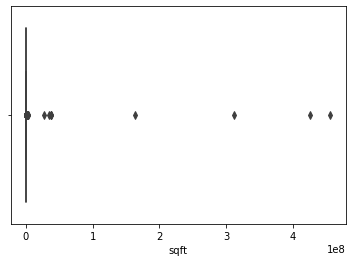

,count,min,mean,max,low_range,upper_range,out_count
sqft,285190.0,0.0,11465.41,795979430.0,-773.5,4702.5,17206.0


In [111]:
# График выбросов
sns.boxplot(x=df_train["sqft"])
plt.show()

# Выбросы
data_out.loc['sqft'].to_frame().T

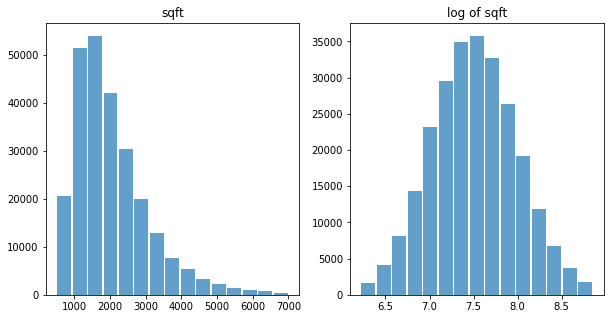

In [112]:
df_hist_plot('sqft', df_train[(df_train['sqft'] >
                               500) & (df_train['sqft'] < 7_000)])

In [113]:
df_train = df_train[(df_train['sqft'] > 500) & (df_train['sqft'] < 7_000)]

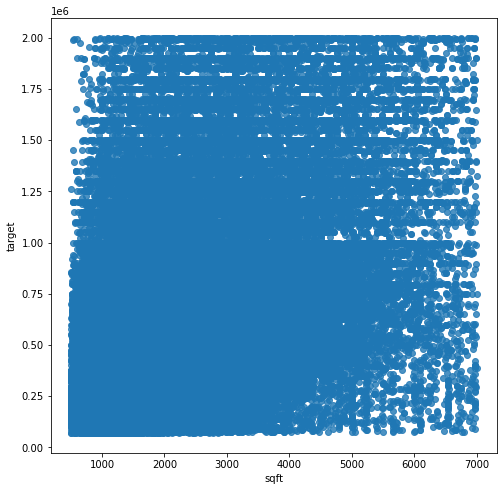

In [114]:
plt.figure(figsize=(8, 8))
sns.regplot(data=df_train, y="target", x="sqft", fit_reg=False)
plt.show()

In [115]:
df_train['sqft_log'] = np.log(df_train['sqft'] + 1)
df_test['sqft_log'] = np.log(df_test['sqft'] + 1)

Year built

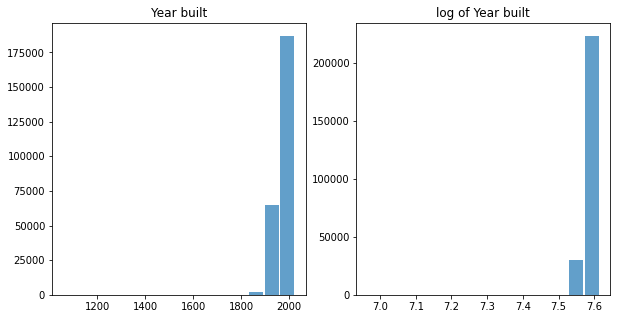

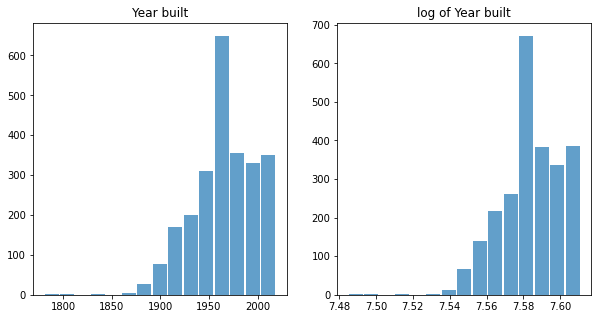

In [116]:
df_hist_plot('Year built', df_train)
df_hist_plot('Year built', df_test)

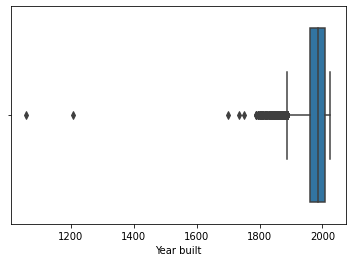

,count,min,mean,max,low_range,upper_range,out_count
Year built,285190.0,1057.0,1979.1,2025.0,1879.5,2083.5,739.0


In [117]:
# График выбросов
sns.boxplot(x=df_train["Year built"])
plt.show()

# Выбросы
data_out.loc['Year built'].to_frame().T

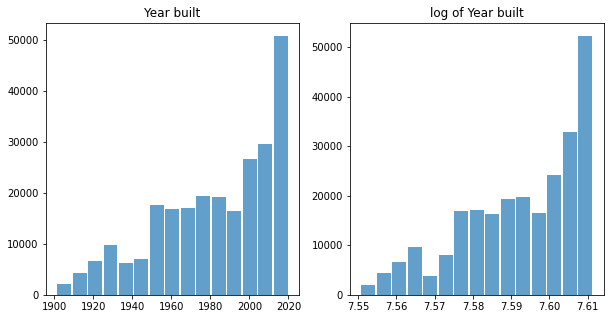

In [118]:
df_hist_plot('Year built', df_train[(
    df_train['Year built'] > 1900) & (df_train['Year built'] <= 2020)])

In [119]:
df_train = df_train[(df_train['Year built'] > 1900) &
                    (df_train['Year built'] <= 2020)]

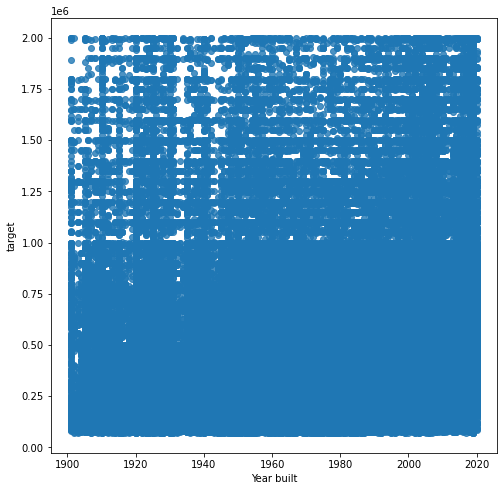

In [120]:
plt.figure(figsize=(8, 8))
sns.regplot(data=df_train, y="target", x="Year built", fit_reg=False)
plt.show()

In [121]:
df_train['year_built_log'] = np.log(df_train['Year built'] + 1)
df_test['year_built_log'] = np.log(df_test['Year built'] + 1)

Dist_max

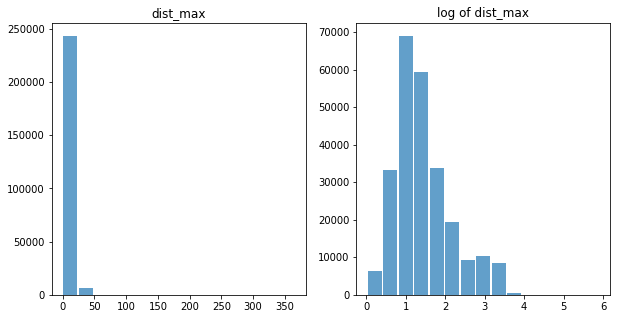

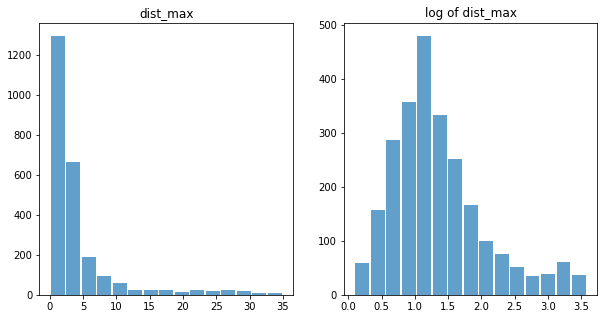

In [122]:
df_hist_plot('dist_max', df_train)
df_hist_plot('dist_max', df_test)

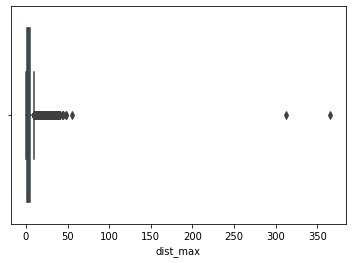

,count,min,mean,max,low_range,upper_range,out_count
dist_max,285190.0,0.02,4.91,1591.09,-3.5,10.1,32788.0


In [123]:
# График выбросов
sns.boxplot(x=df_train["dist_max"])
plt.show()

# Выбросы
data_out.loc['dist_max'].to_frame().T

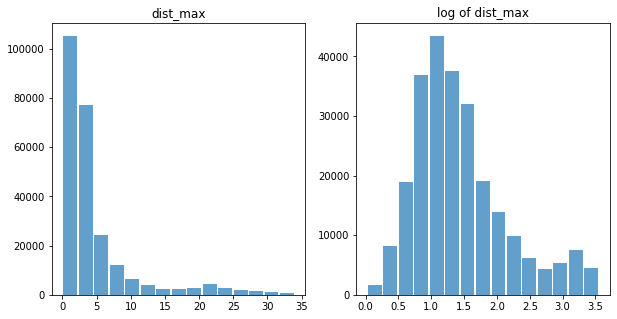

In [124]:
df_hist_plot('dist_max', df_train[df_train['dist_max'] <= 34])

In [125]:
df_train = df_train[df_train['dist_max'] <= 34]

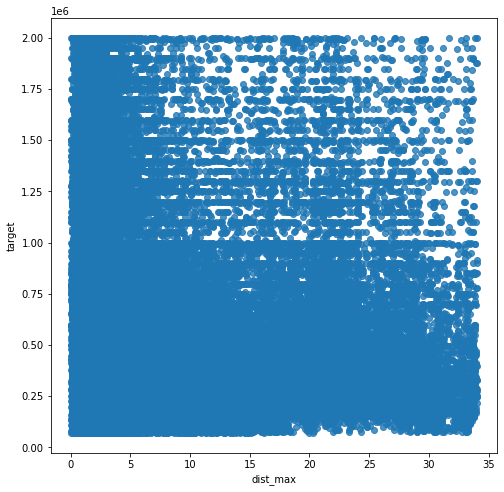

In [126]:
plt.figure(figsize=(8, 8))
sns.regplot(data=df_train, y="target", x="dist_max", fit_reg=False)
plt.show()

In [127]:
df_train['dist_max_log'] = np.log(df_train['dist_max'] + 1)
df_test['dist_max_log'] = np.log(df_test['dist_max'] + 1)

Dist_min

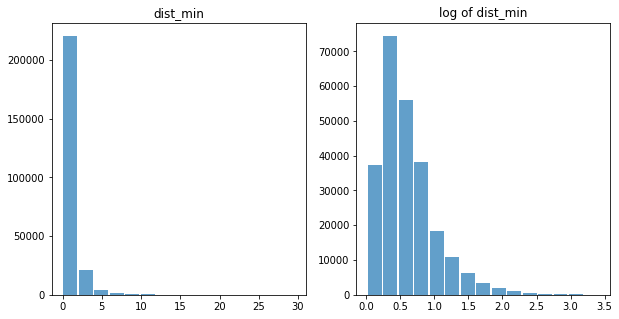

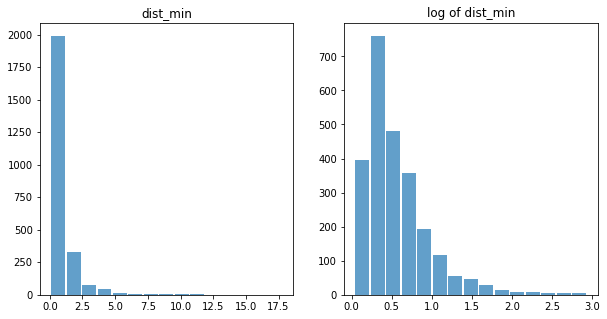

In [128]:
df_hist_plot('dist_min', df_train)
df_hist_plot('dist_min', df_test)

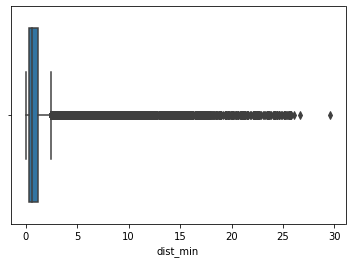

,count,min,mean,max,low_range,upper_range,out_count
dist_min,285190.0,0.01,1.08,1590.38,-0.95,2.49,22413.0


In [129]:
# График выбросов
sns.boxplot(x=df_train["dist_min"])
plt.show()

# Выбросы
data_out.loc['dist_min'].to_frame().T

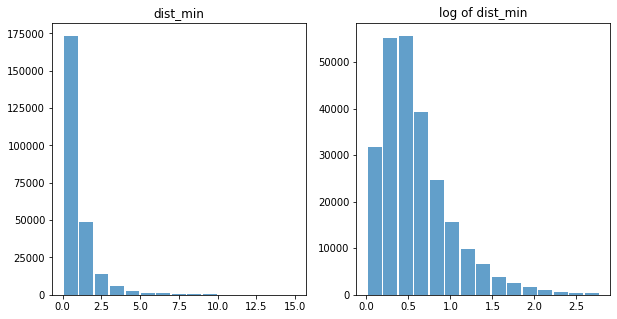

In [130]:
df_hist_plot('dist_min', df_train[(df_train['dist_min'] <= 15)])

In [131]:
df_train = df_train[(df_train['dist_min'] <= 15)]

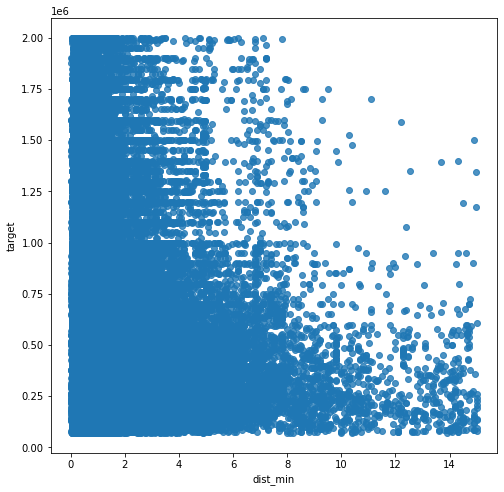

In [132]:
plt.figure(figsize=(8, 8))
sns.regplot(data=df_train, y="target", x="dist_min", fit_reg=False)
plt.show()

In [133]:
df_train['dist_min_log'] = np.log(df_train['dist_min'] + 1)
df_test['dist_min_log'] = np.log(df_test['dist_min'] + 1)

Rate_max

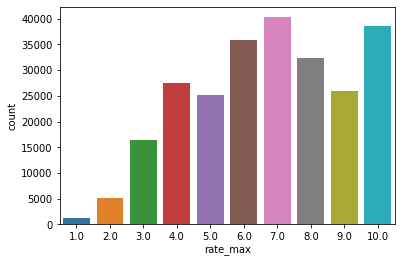

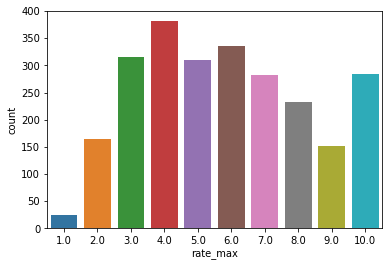

In [134]:
sns.countplot(x=df_train["rate_max"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_max"], data=df_test)
plt.show()

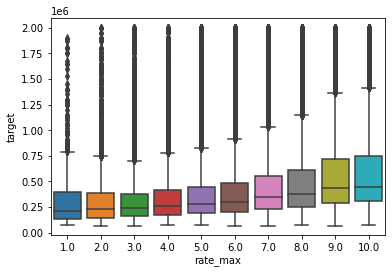

In [135]:
sns.boxplot(data=df_train, x='rate_max', y='target')
plt.show()

Rate_min

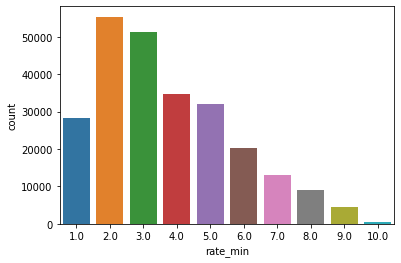

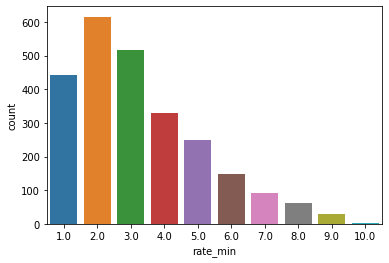

In [136]:
sns.countplot(x=df_train["rate_min"], data=df_train)
plt.show()

sns.countplot(x=df_test["rate_min"], data=df_test)
plt.show()

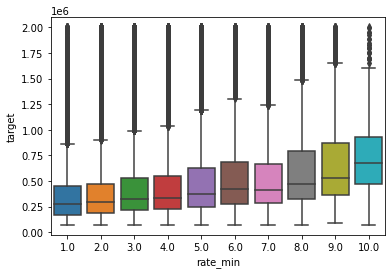

In [137]:
sns.boxplot(data=df_train, x='rate_min', y='target')
plt.show()

# Влияние числовых признаков на target

In [138]:
display(df_train.columns)
print(numerical_features)

Index(['propertyType', 'sqft', 'zipcode', 'state', 'target', 'Year built',
       'dist_max', 'dist_min', 'rate_max', 'rate_min', 'target_log',
       'sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log'],
      dtype='object')

['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min']


In [139]:
# Введем новые числовые признаки
numerical_features = numerical_features + \
    ['sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log']

<AxesSubplot:>

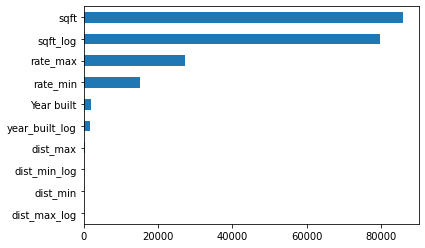

In [140]:
# График влияния числовых переменных на target

df_train_imp = df_train.copy()

# рассмотрим значимость переменных

imp_num = pd.Series(f_regression(df_train_imp[numerical_features],
                                 df_train_imp['target_log'])[0], index=numerical_features)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

# Рассмотрим категориальные признаки

PropertyType

In [141]:
df_train['propertyType'].value_counts()

single family                150574
condo                         34772
townhouse                     14658
multi family                   8336
condo town row                 6791
                              ...  
contemporary other patio          1
colonial english georgian         1
condo town southwestern           1
custom victorian                  1
townhouse villa                   1
Name: propertyType, Length: 712, dtype: int64

In [142]:
df_test['propertyType'].value_counts()

single family                1814
other                         181
condo                         157
apartment                     124
multi family                   48
townhouse                      48
singlefamilyresidence          41
lot land                       20
mobile manufactured            15
multiple occupancy             13
miscellaneous                   8
cooperative                     2
apartment condo townhouse       2
mfd mobile                      1
coop                            1
traditional                     1
federal                         1
contemporary                    1
colonial                        1
unknown                         1
land                            1
Name: propertyType, dtype: int64

In [143]:
# Выделим значения из теста которых нет в трейне

unique_train_type = df_train['propertyType'].unique()

df_test[~df_test['propertyType'].isin(
    unique_train_type)]['propertyType'].value_counts()

singlefamilyresidence        41
apartment condo townhouse     2
Name: propertyType, dtype: int64

In [144]:
# Так как количетсво этих значений мало, заменим на аналогичное из теста

df_test.loc[df_test['propertyType'] ==
            'apartment condo townhouse', 'propertyType'] = 'apartment'
df_test.loc[df_test['propertyType'] ==
            'singlefamilyresidence', 'propertyType'] = 'single family'

In [145]:
unique_type = df_test['propertyType'].unique()

# Удалим строки из трейна, где нет значений из теста
df_train = df_train[df_train['propertyType'].isin(unique_type)]

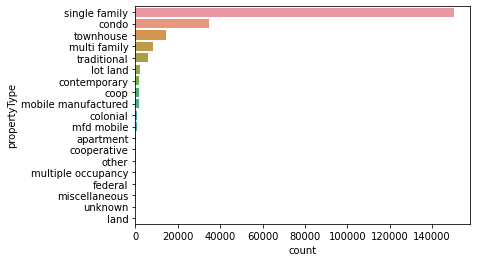

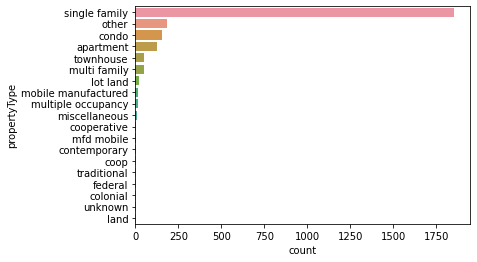

In [146]:
# Посмотрим как распределены значения в трейне и тесте

sns.countplot(y="propertyType", data=df_train,
              order=df_train['propertyType'].value_counts().index)
plt.show()

sns.countplot(y="propertyType", data=df_test,
              order=df_test['propertyType'].value_counts().index)
plt.show()

In [147]:
# Более сильное упрощение данного признака дает результат MAPE хуже, поэтому не будем изменять

Zipcode

In [148]:
df_train['zipcode'].value_counts()

33131    1198
33132     954
33137     912
33130     899
32137     865
         ... 
10707       1
33559       1
32792       1
61102       1
64015       1
Name: zipcode, Length: 3912, dtype: int64

In [149]:
df_test['zipcode'].value_counts()

20019    22
33647    20
11201    19
32209    18
33712    17
         ..
30327     1
02215     1
38115     1
02128     1
04957     1
Name: zipcode, Length: 1163, dtype: int64

In [150]:
# Так как количество уникальных значений слишком много, разделим из согласно правилу 3-2

df_train.loc[:, 'zip_f'] = df_train['zipcode'].apply(lambda x: str(x)[:3])
df_test.loc[:, 'zip_f'] = df_test['zipcode'].apply(lambda x: str(x)[:3])

df_train.loc[:, 'zip_s'] = df_train['zipcode'].apply(lambda x: str(x)[3:])
df_test.loc[:, 'zip_s'] = df_test['zipcode'].apply(lambda x: str(x)[3:])

In [151]:
# Выделим значения из теста которых нет в трейне

unique_train_zipf = df_train['zip_f'].unique()
unique_train_zips = df_train['zip_s'].unique()

display(df_test[~df_test['zip_f'].isin(unique_train_zipf)]
        ['zip_f'].value_counts())
display(df_test[~df_test['zip_s'].isin(unique_train_zips)]
        ['zip_s'].value_counts())

Series([], Name: zip_f, dtype: int64)

Series([], Name: zip_s, dtype: int64)

In [152]:
unique_zipf = df_test['zip_f'].unique()
unique_zips = df_test['zip_s'].unique()

# Удалим строки из трейна, где нет значений в тесте
df_train = df_train[df_train['zip_f'].isin(unique_zipf)]
df_train = df_train[df_train['zip_s'].isin(unique_zips)]

State

In [153]:
df_train['state'].value_counts()

FL    66572
TX    51203
CA    15876
NY    10960
NC    10556
TN     9184
WA     8679
NV     6969
OH     5615
IL     5334
GA     4307
PA     3431
CO     3349
DC     2673
OR     2182
IN     1724
MI     1317
UT      939
MD      607
MO      524
MA      412
VT      288
VA       75
ME       37
DE        2
Name: state, dtype: int64

In [154]:
df_test['state'].value_counts()

FL    782
TX    428
CA    178
OH    156
NY    140
TN    109
DC     89
WA     87
IL     87
NC     76
GA     64
NV     61
PA     51
MI     35
MO     34
IN     34
CO     27
MA     18
OR     11
VT      4
UT      4
MD      4
VA      1
ME      1
Name: state, dtype: int64

In [155]:
# Посмотрим каких значений теста нет в трейне

unique_train_state = df_train['state'].unique()

df_test[~df_test['state'].isin(unique_train_state)]['state'].value_counts()

Series([], Name: state, dtype: int64)

In [156]:
# Удалим те строки в трейне, которых нет в тесте

unique_state = df_test['state'].unique()

df_train = df_train[df_train['state'].isin(unique_state)]

In [157]:
# Добавим новые категориальные признаки

categorical_features = categorical_features + ['zip_f', 'zip_s']

# Влияние категориальных признаков на target

<AxesSubplot:>

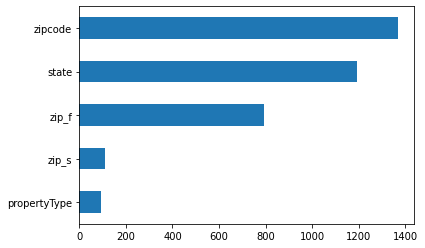

In [158]:
# Теперь рассмотрим значимость категориальных переменных
df_train_cat = df_train.copy()

label_encoder = LabelEncoder()

for feature in categorical_features:
    df_train_cat[feature] = label_encoder.fit_transform(df_train_cat[feature])

imp_cat = pd.Series(f_regression(df_train_cat[categorical_features],
                                 df_train_cat['target_log'])[0], index=categorical_features)

imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

# Prepocess data

In [159]:
numerical_features_copy = numerical_features.copy()
categorical_features_copy = categorical_features.copy()

In [160]:
print(numerical_features_copy)
print(categorical_features_copy)

['sqft', 'Year built', 'dist_max', 'dist_min', 'rate_max', 'rate_min', 'sqft_log', 'year_built_log', 'dist_max_log', 'dist_min_log']
['propertyType', 'zipcode', 'state', 'zip_f', 'zip_s']


In [161]:
# Удаляем признаки из numerical_features_new
for x in ['sqft', 'dist_max', 'dist_min', 'rate_max', 'rate_min', 'year_built_log']:
    numerical_features_copy.remove(x)

# numerical_features_copy.remove('dist_min_log')
# numerical_features_copy.remove('dist_max_log')

categorical_features_copy.remove('zipcode')
# categorical_features_copy.remove('propertyType')
# categorical_features_copy.remove('zip_f')
# categorical_features_copy.remove('zip_s')

for x in ['rate_max', 'rate_min']:
    categorical_features_copy.append(x)

features = numerical_features_copy + categorical_features_copy + ['target_log']
# features = numerical_features_new + categorical_features + ['target']

In [162]:
# Мы знаем, что у трейна нет target=0, все эти данные в тесте, поэтому можем легко их оюъединить

df_input = pd.concat([df_train[features], df_test[features]])

In [163]:
df_input.sample(5)

,Year built,sqft_log,dist_max_log,dist_min_log,propertyType,state,zip_f,zip_s,rate_max,rate_min,target_log
296695,2005.0,8.458716,1.791759,1.098612,single family,NV,895,11,10.0,6.0,14.339056
199127,1928.0,8.082711,2.368373,0.231112,multi family,IL,606,51,2.0,1.0,12.013707
185656,2019.0,6.955593,2.498152,0.239017,condo,MI,482,08,6.0,2.0,12.845294
220014,1932.0,7.990577,0.832909,0.693147,single family,GA,303,18,7.0,6.0,13.548939
122459,1964.0,7.619233,1.064711,0.470004,single family,TX,752,28,4.0,2.0,12.765691


In [164]:
poly = PolynomialFeatures(degree=1, include_bias=False)

df_numerical_poly = pd.DataFrame(
    poly.fit_transform(df_input[numerical_features_copy]))

Замечание: числовые полиномиальные признаки с критерием (degree=2, 3) не дают улучшения модели

In [165]:
df_numerical_poly.shape

(215294, 4)

In [166]:
# One-Hot Encoding
df_categorical_dummy = pd.get_dummies(
    df_input[categorical_features_copy], dummy_na=False).reset_index(drop=True)

In [167]:
df_preproc = pd.concat([df_numerical_poly,
                        df_categorical_dummy,
                        pd.Series(df_input['target_log']).reset_index(drop=True)], axis=1)

In [168]:
df_preproc.shape

(215294, 360)

(215294, 360)

# Split data to Train/Test

In [169]:
# Теперь выделим тестовую часть
train_data = df_preproc[df_preproc['target_log'] != 0]
test_data = df_preproc[df_preproc['target_log'] == 0]

X_train_num = train_data[df_numerical_poly.columns].values
X_test_num = test_data[df_numerical_poly.columns].values

X_train_cat = train_data[df_categorical_dummy.columns].values
X_test_cat = test_data[df_categorical_dummy.columns].values

In [170]:
# Scaler
scaler = StandardScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

In [171]:
X = np.hstack([X_train_num, X_train_cat])
Y = train_data['target_log'].values
test_val = np.hstack([X_test_num, X_test_cat])

Select Kbest

In [172]:
# selector = SelectKBest(score_func=f_regression, k=300)

# X = selector.fit_transform(X, Y)
# cols = selector.get_support(indices=True)
# test_val = test_val[:, cols]

Замечание: уменьшение количества признаков не улучшает результат модели

# Trying to save changes and load it

In [173]:
#import dill
# dill.dump_session('notebook_env.db')
# dill.load_session('notebook_env.db')

# SPLIT

In [174]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

# CatBoostRegressor

In [173]:
model_cbr = CatBoostRegressor(iterations=1000,
                              # depth=8,
                              #learning_rate = 0.42,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE'],
                              od_wait=100,
                              # task_type='GPU',
                              )

model_cbr.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose_eval=0,
              use_best_model=True,
              )

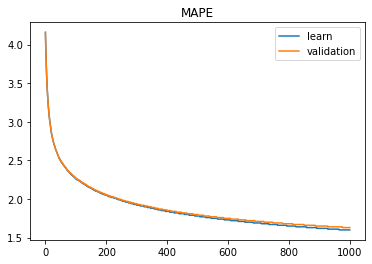

In [174]:
# График обучения

learn_mape = [round(x * 100, 2)
              for x in model_cbr.evals_result_['learn']['MAPE']]
valid_mape = [round(x * 100, 2)
              for x in model_cbr.evals_result_['validation']['MAPE']]

plt.title('MAPE')
plt.plot(learn_mape, label='learn')
plt.plot(valid_mape, label='validation')
plt.legend()
plt.show()

In [ ]:
y_pred = model_cbr.predict(X_test)

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(
    f"TEST mape: {mean_absolute_percentage_error(y_test_exp, y_pred_exp)*100:0.2f}%")

Результат на 1000 21.39%

Результат на 5000 19.83%

## Настройка оценки grid_search

In [ ]:
model_cbr = CatBoostRegressor(iterations=1000,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              od_wait=100,
                              )

parameters = {'depth': sp_randInt(4, 10),
              'learning_rate': sp_randFloat(),
              }

randm = RandomizedSearchCV(
    estimator=model_cbr, param_distributions=parameters, n_jobs=-1)

randm.fit(X_train, y_train, verbose_eval=0)

best_param = randm.best_params_
best_param

Результат на 1000 depth 8, learning rate = 0.43

Результат на 1000 depth 9, learning rate = 0.24

In [ ]:
# Использование в модели

model_cbr = CatBoostRegressor(iterations=5_000,
                              depth=9,
                              learning_rate=0.24,
                              random_seed=RANDOM_SEED,
                              eval_metric='MAPE',
                              custom_metric=['RMSE'],
                              od_wait=100,
                              # task_type='GPU',
                              )

model_cbr.fit(X_train, y_train,
              eval_set=(X_test, y_test),
              verbose_eval=0,
              use_best_model=True,
              )

y_pred = model_cbr.predict(X_test)

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

print(
    f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

Результат на 5000, depth=8, learning rate = 0.42 значение 16.85%

Результат на 5000, depth=9, learning rate = 0.24 значение 16.49%

# XGBoost

In [181]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [192]:
model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED)


# Обучаем модель и делаем предсказание
model_xgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric=['mape']
                )
    
y_pred = model_xgb.predict(X_test)
    
# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

[0]	validation_0-mape:0.67209	validation_1-mape:0.67221
[1]	validation_0-mape:0.47006	validation_1-mape:0.47029
[2]	validation_0-mape:0.32866	validation_1-mape:0.32892
[3]	validation_0-mape:0.22966	validation_1-mape:0.22997
[4]	validation_0-mape:0.16039	validation_1-mape:0.16069
[5]	validation_0-mape:0.11196	validation_1-mape:0.11228
[6]	validation_0-mape:0.07843	validation_1-mape:0.07873
[7]	validation_0-mape:0.05593	validation_1-mape:0.05617
[8]	validation_0-mape:0.04164	validation_1-mape:0.04184
[9]	validation_0-mape:0.03308	validation_1-mape:0.03327
[10]	validation_0-mape:0.02839	validation_1-mape:0.02859
[11]	validation_0-mape:0.02585	validation_1-mape:0.02605
[12]	validation_0-mape:0.02459	validation_1-mape:0.02475
[13]	validation_0-mape:0.02392	validation_1-mape:0.02407
[14]	validation_0-mape:0.02344	validation_1-mape:0.02358
[15]	validation_0-mape:0.02313	validation_1-mape:0.02326
[16]	validation_0-mape:0.02289	validation_1-mape:0.02302
[17]	validation_0-mape:0.02262	validation

Результат 24.13%

## Настройка оценки grid_search

In [205]:
model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED)

parameters = {'n_estimators': sp_randInt(50, 200),
                'max_depth': sp_randInt(4, 10),
                'learning_rate': sp_randFloat(),
              }

randm = RandomizedSearchCV(
    estimator=model_xgb, param_distributions=parameters, n_jobs=-1)

randm.fit(X_train, y_train)

best_param = randm.best_params_
best_param

{'learning_rate': 0.3540776019402492, 'max_depth': 7, 'n_estimators': 198}

{'learning_rate': 0.3540776019402492, 'max_depth': 7, 'n_estimators': 198}

In [206]:
# Использование в модели

model_xgb = xgb.XGBRegressor(random_state=RANDOM_SEED,
                            n_estimators=198,
                            max_depth=7,
                            learning_rate=0.354
                            )


# Обучаем модель и делаем предсказание
model_xgb.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_metric=['mape']
                )
    
y_pred = model_xgb.predict(X_test)
    
# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

[0]	validation_0-mape:0.62017	validation_1-mape:0.62031
[1]	validation_0-mape:0.40021	validation_1-mape:0.40045
[2]	validation_0-mape:0.25812	validation_1-mape:0.25837
[3]	validation_0-mape:0.16635	validation_1-mape:0.16664
[4]	validation_0-mape:0.10714	validation_1-mape:0.10746
[5]	validation_0-mape:0.06941	validation_1-mape:0.06970
[6]	validation_0-mape:0.04656	validation_1-mape:0.04682
[7]	validation_0-mape:0.03387	validation_1-mape:0.03409
[8]	validation_0-mape:0.02755	validation_1-mape:0.02778
[9]	validation_0-mape:0.02456	validation_1-mape:0.02479
[10]	validation_0-mape:0.02326	validation_1-mape:0.02345
[11]	validation_0-mape:0.02262	validation_1-mape:0.02281
[12]	validation_0-mape:0.02230	validation_1-mape:0.02250
[13]	validation_0-mape:0.02206	validation_1-mape:0.02227
[14]	validation_0-mape:0.02191	validation_1-mape:0.02212
[15]	validation_0-mape:0.02168	validation_1-mape:0.02192
[16]	validation_0-mape:0.02160	validation_1-mape:0.02184
[17]	validation_0-mape:0.02145	validation

Результат 20.47%

# LGBMRegressor

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [233]:
model_lgbm = LGBMRegressor(random_state=RANDOM_SEED)


# Обучаем модель и делаем предсказание
model_lgbm.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_names=['train', 'valid'],
               eval_metric='mape',
              )
    
y_pred = model_lgbm.predict(X_test)
    
# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"\nTEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

[1]	train's mape: 0.0415363	train's l2: 0.43763	valid's mape: 0.0413782	valid's l2: 0.434476
[2]	train's mape: 0.0395808	train's l2: 0.399839	valid's mape: 0.0394566	valid's l2: 0.39725
[3]	train's mape: 0.0378908	train's l2: 0.36832	valid's mape: 0.0377848	valid's l2: 0.366101
[4]	train's mape: 0.0365056	train's l2: 0.342866	valid's mape: 0.0364138	valid's l2: 0.341066
[5]	train's mape: 0.0352942	train's l2: 0.321238	valid's mape: 0.03523	valid's l2: 0.319931
[6]	train's mape: 0.0342601	train's l2: 0.303441	valid's mape: 0.034204	valid's l2: 0.3023
[7]	train's mape: 0.0332778	train's l2: 0.287211	valid's mape: 0.0332309	valid's l2: 0.286213
[8]	train's mape: 0.0324571	train's l2: 0.273637	valid's mape: 0.0324234	valid's l2: 0.272875
[9]	train's mape: 0.031725	train's l2: 0.261953	valid's mape: 0.0316985	valid's l2: 0.261371
[10]	train's mape: 0.0310881	train's l2: 0.252317	valid's mape: 0.031068	valid's l2: 0.251828
[11]	train's mape: 0.0304759	train's l2: 0.242935	valid's mape: 0.030

Результат 25.77%

## Настройка оценки grid_search

In [234]:
model_lgbm = LGBMRegressor(random_state=RANDOM_SEED)

parameters = {'n_estimators': sp_randInt(10, 500),
                'max_depth': sp_randInt(1, 10),
                'learning_rate': sp_randFloat(),
              }

randm = RandomizedSearchCV(
    estimator=model_lgbm, param_distributions=parameters, n_jobs=-1)

randm.fit(X_train, y_train)

best_param = randm.best_params_
best_param

{'learning_rate': 0.29787695722950025, 'max_depth': 8, 'n_estimators': 357}

{'learning_rate': 0.699582719619244, 'max_depth': 6, 'n_estimators': 179}

{'learning_rate': 0.29787695722950025, 'max_depth': 8, 'n_estimators': 357}

In [235]:
model_lgbm = LGBMRegressor(random_state=RANDOM_SEED,
                            n_estimators=357,
                            max_depth=8,
                            learning_rate=0.3
                        )


# Обучаем модель и делаем предсказание
model_lgbm.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_names=['train', 'valid'],
               eval_metric='mape'
              )
    
y_pred = model_lgbm.predict(X_test)
    
# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"\nTEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

[1]	train's mape: 0.0375006	train's l2: 0.360327	valid's mape: 0.0373923	valid's l2: 0.35811
[2]	train's mape: 0.0336516	train's l2: 0.293529	valid's mape: 0.033592	valid's l2: 0.29239
[3]	train's mape: 0.0312558	train's l2: 0.255153	valid's mape: 0.031232	valid's l2: 0.25474
[4]	train's mape: 0.0296314	train's l2: 0.230194	valid's mape: 0.0296168	valid's l2: 0.230025
[5]	train's mape: 0.0283055	train's l2: 0.211431	valid's mape: 0.028301	valid's l2: 0.21174
[6]	train's mape: 0.0272066	train's l2: 0.197238	valid's mape: 0.0271899	valid's l2: 0.197348
[7]	train's mape: 0.0264663	train's l2: 0.187645	valid's mape: 0.026446	valid's l2: 0.187829
[8]	train's mape: 0.0258767	train's l2: 0.180387	valid's mape: 0.0258554	valid's l2: 0.180847
[9]	train's mape: 0.0251315	train's l2: 0.171883	valid's mape: 0.0251016	valid's l2: 0.172463
[10]	train's mape: 0.0247439	train's l2: 0.16687	valid's mape: 0.0247244	valid's l2: 0.167635
[11]	train's mape: 0.0242397	train's l2: 0.16148	valid's mape: 0.024

Результат 20.57%

Результат 19.67%

Однако, из-за скорости  LGBMRegressor, у него можно лучше оптимизировать параметры не затрачивая очень много времени. Сделаем это дальше 

In [179]:
model_lgbm = LGBMRegressor(random_state=RANDOM_SEED)

parameters = {'num_leaves': sp_randInt(1, 100),
                'max_depth': sp_randInt(1, 20),
                'learning_rate': sp_randFloat(),
                'n_estimators': sp_randInt(1, 500),
                'reg_alpha': sp_randFloat(),
                'reg_lambda': sp_randFloat(),
              }

randm = RandomizedSearchCV(
    estimator=model_lgbm, param_distributions=parameters, n_jobs=-1)

randm.fit(X_train, y_train)

best_param = randm.best_params_
best_param

{'learning_rate': 0.5602524497659223,
 'max_depth': 9,
 'n_estimators': 317,
 'num_leaves': 84,
 'reg_alpha': 0.05106588126592537,
 'reg_lambda': 0.5457826453599811}

{'learning_rate': 0.6802503916713403,
 'max_depth': 6,
 'n_estimators': 151,
 'num_leaves': 49,
 'reg_alpha': 0.0508184075464535,
 'reg_lambda': 0.8580470367296443}

 {'learning_rate': 0.5602524497659223,
 'max_depth': 9,
 'n_estimators': 317,
 'num_leaves': 84,
 'reg_alpha': 0.05106588126592537,
 'reg_lambda': 0.5457826453599811}

In [181]:
model_lgbm = LGBMRegressor(random_state=RANDOM_SEED,
                            learning_rate=0.56,
                            max_depth=9,
                            n_estimators=317,
                            num_leaves=84,
                            reg_alpha=0.051,
                            reg_lambda=0.546
                        )


# Обучаем модель и делаем предсказание
model_lgbm.fit(X_train, y_train,
               eval_set=[(X_train, y_train), (X_test, y_test)],
               eval_names=['train', 'valid'],
               eval_metric='mape'
              )
    
y_pred = model_lgbm.predict(X_test)
    
# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"\nTEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

[1]	train's mape: 0.0318473	train's l2: 0.263471	valid's mape: 0.0317975	valid's l2: 0.262626
[2]	train's mape: 0.0275001	train's l2: 0.201484	valid's mape: 0.027499	valid's l2: 0.202125
[3]	train's mape: 0.0251067	train's l2: 0.171612	valid's mape: 0.0251506	valid's l2: 0.173262
[4]	train's mape: 0.0238145	train's l2: 0.157051	valid's mape: 0.023898	valid's l2: 0.158877
[5]	train's mape: 0.0229986	train's l2: 0.148108	valid's mape: 0.0231012	valid's l2: 0.150339
[6]	train's mape: 0.0224877	train's l2: 0.142406	valid's mape: 0.0226156	valid's l2: 0.14516
[7]	train's mape: 0.0220177	train's l2: 0.137487	valid's mape: 0.0221455	valid's l2: 0.140445
[8]	train's mape: 0.0216719	train's l2: 0.133834	valid's mape: 0.0218242	valid's l2: 0.137034
[9]	train's mape: 0.021394	train's l2: 0.131064	valid's mape: 0.021584	valid's l2: 0.134857
[10]	train's mape: 0.0212079	train's l2: 0.128861	valid's mape: 0.021406	valid's l2: 0.132858
[11]	train's mape: 0.0210305	train's l2: 0.126895	valid's mape: 0

Результат 20.83%

Результат 19.04%

# RandomForestRegressor

In [175]:
model_rfr = RandomForestRegressor(random_state=RANDOM_SEED)

# Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

mape_kfold = []

for train_idx, test_idx in tqdm(kf.split(X, Y), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Обучаем модель и делаем предсказание
    model_rfr.fit(X_train, y_train)
    y_pred = model_rfr.predict(X_test)
    
    # Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
    y_pred_exp = np.round(np.exp(y_pred) - 1)
    y_test_exp = np.round(np.exp(y_test) - 1)

    mape_value = round(mape(y_test_exp, y_pred_exp)*100, 3)
    mape_kfold.append(mape_value)
                       
    print(f"test MAPE: {mape_value}%")

# Вывод результата MAPE
print(f"mean MAPE: {mean(mape_kfold)}%")

k-fold:  20%|██        | 1/5 [24:57<1:39:48, 1497.05s/it]

test MAPE: 18.488%


k-fold:  40%|████      | 2/5 [48:11<1:11:50, 1436.72s/it]

test MAPE: 18.748%


k-fold:  60%|██████    | 3/5 [1:09:56<45:53, 1376.54s/it]

test MAPE: 19.002%


k-fold:  80%|████████  | 4/5 [1:31:52<22:32, 1352.80s/it]

test MAPE: 18.43%


k-fold: 100%|██████████| 5/5 [1:55:36<00:00, 1387.21s/it]

test MAPE: 19.004%
mean MAPE: 18.7344%


Результат 18.73%

## Настройка оценки grid_search

In [ ]:
model_rfr = RandomForestRegressor(random_state=RANDOM_SEED)


parameters = {'max_depth': [None, sp_randInt(4, 10)],
              'n_estimators': sp_randInt(70, 150),
              'max_features': ['auto', 'sqrt', 'log2'],
              }

randm_rfr = RandomizedSearchCV(
    estimator=model_rfr, param_distributions=parameters, n_jobs=-1)

randm_rfr.fit(X_train, y_train)

best_param = randm_rfr.best_params_
best_param

Результат max_depth = None, n_estimators = 109, max_features = 'log2'

In [176]:
# Использование в модели

model_rfr = RandomForestRegressor(
    random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2')

# Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

mape_kfold = []

for train_idx, test_idx in tqdm(kf.split(X, Y), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Обучаем модель и делаем предсказание
    model_rfr.fit(X_train, y_train)
    y_pred = model_rfr.predict(X_test)
    
    # Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
    y_pred_exp = np.round(np.exp(y_pred) - 1)
    y_test_exp = np.round(np.exp(y_test) - 1)

    mape_value = round(mape(y_test_exp, y_pred_exp)*100, 3)
    mape_kfold.append(mape_value)
                       
    print(f"test MAPE: {mape_value}%")

# Вывод результата MAPE
print(f"mean MAPE: {mean(mape_kfold)}%")

k-fold:  20%|██        | 1/5 [02:29<09:57, 149.42s/it]

test MAPE: 16.848%


k-fold:  40%|████      | 2/5 [05:01<07:32, 150.76s/it]

test MAPE: 17.074%


k-fold:  60%|██████    | 3/5 [07:35<05:04, 152.23s/it]

test MAPE: 17.165%


k-fold:  80%|████████  | 4/5 [10:13<02:34, 154.79s/it]

test MAPE: 16.895%


k-fold: 100%|██████████| 5/5 [12:37<00:00, 151.48s/it]

test MAPE: 17.342%
mean MAPE: 17.064799999999998%


Результат на max_depth=None, n_estimators=109, max_features='log2' значение 17.06%

# KNeighborsRegressor

In [177]:
model_knr = KNeighborsRegressor()

# Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

mape_kfold = []

for train_idx, test_idx in tqdm(kf.split(X, Y), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Обучаем модель и делаем предсказание
    model_knr.fit(X_train, y_train)
    y_pred = model_knr.predict(X_test)
    
    # Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
    y_pred_exp = np.round(np.exp(y_pred) - 1)
    y_test_exp = np.round(np.exp(y_test) - 1)

    mape_value = round(mape(y_test_exp, y_pred_exp)*100, 3)
    mape_kfold.append(mape_value)
                       
    print(f"test MAPE: {mape_value}%")

# Вывод результата MAPE
print(f"mean MAPE: {mean(mape_kfold)}%")

k-fold:  20%|██        | 1/5 [02:41<10:45, 161.35s/it]

test MAPE: 19.785%


k-fold:  40%|████      | 2/5 [05:24<08:07, 162.49s/it]

test MAPE: 20.098%


k-fold:  60%|██████    | 3/5 [08:02<05:20, 160.23s/it]

test MAPE: 20.132%


k-fold:  80%|████████  | 4/5 [10:50<02:43, 163.31s/it]

test MAPE: 19.756%


k-fold: 100%|██████████| 5/5 [13:22<00:00, 160.56s/it]

test MAPE: 20.307%
mean MAPE: 20.0156%


Результат 20.02%

## Настройка оценки grid_search

In [ ]:
model_knr = KNeighborsRegressor()


parameters = {'n_neighbors': sp_randInt(4, 10),
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': sp_randInt(20, 50),
              }

randm_knr = RandomizedSearchCV(
    estimator=model_knr, param_distributions=parameters, n_jobs=-1)

randm_knr.fit(X_train, y_train)

best_param = randm_knr.best_params_
best_param

Результат algorithm= 'ball_tree', leaf_size = 33, n_neighbors = 5

In [175]:
# Используем в модели

model_knr = KNeighborsRegressor(
    n_neighbors=5, algorithm='ball_tree', leaf_size=33)

# Kfold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

mape_kfold = []

for train_idx, test_idx in tqdm(kf.split(X, Y), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    # Обучаем модель и делаем предсказание
    model_knr.fit(X_train, y_train)
    y_pred = model_knr.predict(X_test)
    
    # Преобразуем Y_test, y_pred к exp значениям для оценки MAPE
    y_pred_exp = np.round(np.exp(y_pred) - 1)
    y_test_exp = np.round(np.exp(y_test) - 1)

    mape_value = round(mape(y_test_exp, y_pred_exp)*100, 3)
    mape_kfold.append(mape_value)
                       
    print(f"test MAPE: {mape_value}%")

# Вывод результата MAPE
print(f"mean MAPE: {mean(mape_kfold)}%")

k-fold:  20%|██        | 1/5 [21:41<1:26:46, 1301.61s/it]

test MAPE: 19.786%


k-fold:  40%|████      | 2/5 [42:57<1:04:19, 1286.38s/it]

test MAPE: 20.098%


k-fold:  60%|██████    | 3/5 [1:03:54<42:25, 1272.98s/it]

test MAPE: 20.132%


k-fold:  80%|████████  | 4/5 [1:24:51<21:06, 1266.63s/it]

test MAPE: 19.757%


k-fold: 100%|██████████| 5/5 [1:46:08<00:00, 1273.60s/it]

test MAPE: 20.309%
mean MAPE: 20.0164%


Результат на n_neighbors=5, algorithm='ball_tree', leaf_size=33 значение 20.02%

# GradientBoostingRegressor

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

In [177]:
model_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED)

model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)


# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)


# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 33.48%


Результат 33.48%

## Настройка оценки grid_search

In [192]:
model_gbr = GradientBoostingRegressor(random_state=RANDOM_SEED)


parameters = {'loss': ['ls', 'lad', 'huber', 'quantile'],
              'learning_rate': sp_randFloat(),
              'n_estimators': sp_randInt(50, 200),
              }

randm_gbr = RandomizedSearchCV(
    estimator=model_gbr, param_distributions=parameters, n_jobs=-1)

randm_gbr.fit(X_train, y_train)

best_param = randm_gbr.best_params_
best_param

Параметры: learning_rate': 0.7166118271133564, 'loss': 'ls', 'n_estimators': 155

In [175]:
model_gbr = GradientBoostingRegressor(learning_rate=0.7166,
                                      loss='ls',
                                      n_estimators=155,
                                      random_state=RANDOM_SEED)

model_gbr.fit(X_train, y_train)
y_pred = model_gbr.predict(X_test)


# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)


# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 24.56%


Результат на learning_rate': 0.7166118271133564, 'loss': 'ls', 'n_estimators': 155 значение 24.56%

# TabNet

In [176]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [183]:
model_tabnet = TabNetRegressor(verbose=50, seed=RANDOM_SEED)


model_tabnet.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_name=['train', 'valid'],
              #patience=300, max_epochs=2000,
              patience=100, max_epochs=500,
              eval_metric=['rmse'])

y_pred = model_tabnet.predict(X_test)


# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)


# Вывод результата MAPE
print(f"\n\nTEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.3f}%")


Device used : cpu
epoch 0  | loss: 18.57647| train_rmse: 0.67125 | valid_rmse: 0.66985 |  0:00:54s
epoch 50 | loss: 0.08457 | train_rmse: 0.29462 | valid_rmse: 0.30371 |  0:44:48s
epoch 100| loss: 0.07937 | train_rmse: 0.27651 | valid_rmse: 0.28907 |  1:28:40s
epoch 150| loss: 0.08144 | train_rmse: 0.27169 | valid_rmse: 0.28999 |  2:12:23s
epoch 200| loss: 0.07855 | train_rmse: 0.26953 | valid_rmse: 0.28562 |  2:57:13s
epoch 250| loss: 0.07512 | train_rmse: 0.25712 | valid_rmse: 0.27514 |  3:42:36s
epoch 300| loss: 0.07257 | train_rmse: 0.26058 | valid_rmse: 0.28293 |  4:27:58s
epoch 350| loss: 0.0697  | train_rmse: 0.24391 | valid_rmse: 0.26673 |  5:13:30s
epoch 400| loss: 0.07133 | train_rmse: 0.24349 | valid_rmse: 0.26931 |  5:57:02s
epoch 450| loss: 0.06895 | train_rmse: 0.25035 | valid_rmse: 0.275   |  6:40:54s
Stop training because you reached max_epochs = 500 with best_epoch = 458 and best_valid_rmse = 0.26467
Best weights from best epoch are automatically used!


TEST mape: 19.

Результат на 100 19.93%
Результат на 500 19.22%

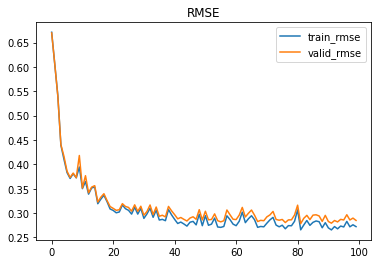

In [181]:
# График обучения

plt.title('RMSE')
plt.plot(model_tabnet.history['train_rmse'], label='train_rmse')
plt.plot(model_tabnet.history['valid_rmse'], label='valid_rmse')
plt.legend()
plt.show()

## Настройка оценки grid_search

In [175]:
model_tabnet = TabNetRegressor(verbose=0, seed=RANDOM_SEED)


parameters = {'n_independent': sp_randInt(2, 5),
              'n_steps': sp_randInt(3, 5),
              }

randm = RandomizedSearchCV(
    estimator=model_tabnet, param_distributions=parameters, n_jobs=-1, scoring='neg_root_mean_squared_error')

randm.fit(X_train, y_train, 
          #verbose_eval=0,
          #eval_set=[(X_test, y_test)],
          #patience=300, max_epochs=2000,
          #patience=100, max_epochs=100
         )

best_param = randm.best_params_
best_param

No early stopping will be performed, last training weights will be used.


{'n_independent': 3, 'n_steps': 3}

Результат 'n_independent': 3, 'n_steps': 3

In [177]:
model_tabnet = TabNetRegressor(verbose=10, seed=RANDOM_SEED,
                               n_independent=3, n_steps=3,
                              )

model_tabnet.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              eval_name=['train', 'valid'],
              #patience=300, max_epochs=2000,
              patience=100, max_epochs=100,
              eval_metric=['rmse'])

y_pred = model_tabnet.predict(X_test)


# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)


# Вывод результата MAPE
print(f"\n\nTEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.3f}%")


Device used : cpu
epoch 0  | loss: 24.62438| train_rmse: 0.7229  | valid_rmse: 0.72174 |  0:01:09s
epoch 10 | loss: 0.11907 | train_rmse: 0.34749 | valid_rmse: 0.34757 |  0:12:46s
epoch 20 | loss: 0.09891 | train_rmse: 0.31101 | valid_rmse: 0.31668 |  0:22:43s
epoch 30 | loss: 0.08992 | train_rmse: 0.28639 | valid_rmse: 0.29674 |  0:31:49s
epoch 40 | loss: 0.0907  | train_rmse: 0.28033 | valid_rmse: 0.29197 |  0:41:33s
epoch 50 | loss: 0.08887 | train_rmse: 0.2786  | valid_rmse: 0.28922 |  0:50:56s
epoch 60 | loss: 0.08339 | train_rmse: 0.26967 | valid_rmse: 0.28422 |  1:00:23s
epoch 70 | loss: 0.07931 | train_rmse: 0.25671 | valid_rmse: 0.27451 |  1:09:35s
epoch 80 | loss: 0.07705 | train_rmse: 0.25893 | valid_rmse: 0.27756 |  1:19:03s
epoch 90 | loss: 0.07791 | train_rmse: 0.25406 | valid_rmse: 0.27444 |  1:28:26s
Stop training because you reached max_epochs = 100 with best_epoch = 87 and best_valid_rmse = 0.27033
Best weights from best epoch are automatically used!


TEST mape: 20.0

Результат 20.10%

Замечение: из данных моделей (которые можно использовать в качестве метаалгоритма) самый быстрый LGBMRegressor.

Результат лучше всего у CatBoostRegressor.

# Stacking

In [189]:
# Оптимизируем модель


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)


estimators = [
    ('knr', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2'))
]

final_model =  CatBoostRegressor(iterations=1000,
                                depth=9,
                                learning_rate=0.24,
                                random_seed=RANDOM_SEED,
                                eval_metric='MAPE',
                                #custom_metric=['RMSE'],
                                od_wait=100,
                                # task_type='GPU',
                                )

model_str = StackingRegressor(
    estimators=estimators,
    final_estimator=final_model,
    passthrough=True,
    #verbose=10,
    n_jobs=-1
)

In [190]:
# Обучаем модель

model_str.fit(X_train, y_train)

y_pred = model_str.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

0:	learn: 0.0347430	total: 57.9ms	remaining: 57.8s
1:	learn: 0.0280889	total: 88.5ms	remaining: 44.2s
2:	learn: 0.0231542	total: 119ms	remaining: 39.5s
3:	learn: 0.0196954	total: 152ms	remaining: 37.9s
4:	learn: 0.0174085	total: 182ms	remaining: 36.2s
5:	learn: 0.0158455	total: 227ms	remaining: 37.6s
6:	learn: 0.0148487	total: 258ms	remaining: 36.6s
7:	learn: 0.0142488	total: 292ms	remaining: 36.2s
8:	learn: 0.0138861	total: 335ms	remaining: 36.9s
9:	learn: 0.0136699	total: 377ms	remaining: 37.4s
10:	learn: 0.0135232	total: 411ms	remaining: 36.9s
11:	learn: 0.0134411	total: 449ms	remaining: 36.9s
12:	learn: 0.0133809	total: 512ms	remaining: 38.9s
13:	learn: 0.0133379	total: 576ms	remaining: 40.5s
14:	learn: 0.0133017	total: 623ms	remaining: 40.9s
15:	learn: 0.0132702	total: 692ms	remaining: 42.6s
16:	learn: 0.0132495	total: 727ms	remaining: 42s
17:	learn: 0.0132297	total: 779ms	remaining: 42.5s
18:	learn: 0.0132164	total: 804ms	remaining: 41.5s
19:	learn: 0.0131964	total: 853ms	remaini

Результат на 100 итерациях значение 16.84%

Результат на 500 итерациях значение 16.93%

Результат на 100 с passthrough=True значение 16.27%

Результат на 500 с passthrough=True значение 16.03%

Результат на 1000 с passthrough=True значение 15.97%

# Stacking_2

In [177]:
# Оптимизируем модель


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)


estimators = [
    ('knr', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2'))
]


final_model = GradientBoostingRegressor(learning_rate=0.7166,
                                        loss='ls',
                                        n_estimators=155,
                                        random_state=RANDOM_SEED)

model_str = StackingRegressor(
    estimators=estimators,
    final_estimator=final_model,
    passthrough=True,
    #verbose=10,
    n_jobs=-1
)

In [178]:
# Обучаем модель

model_str.fit(X_train, y_train)

y_pred = model_str.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 16.41%


Результат 17.01%

Результат c passthrough=True значение 16.41%

# Stacking_3

In [189]:
# Оптимизируем модель


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)


estimators = [
    ('knr', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2'))
]


final_model = xgb.XGBRegressor(random_state=RANDOM_SEED,
                            #n_estimators=198,
                            #max_depth=7,
                            #learning_rate=0.354
                            )

model_str = StackingRegressor(
    estimators=estimators,
    final_estimator=final_model,
    passthrough=True,
    #verbose=10,
    n_jobs=-1
)

In [190]:
# Обучаем модель

model_str.fit(X_train, y_train)

y_pred = model_str.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 16.22%


Результат 17.19%

Результат c passthrough=True значение 16.26%

Результат без оптимизации c passthrough=True значение 16.22%

# Stacking_4

In [181]:
# Оптимизируем модель


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, shuffle=True, random_state=RANDOM_SEED)


estimators = [
    ('knr', KNeighborsRegressor()),
    ('rfr', RandomForestRegressor(random_state=RANDOM_SEED, max_depth=None, n_estimators=109, max_features='log2'))
]


final_model = LGBMRegressor(random_state=RANDOM_SEED,
                            #learning_rate=0.56,
                            #max_depth=9,
                            #n_estimators=317,
                            #num_leaves=84,
                            #reg_alpha=0.051,
                            #reg_lambda=0.546
                        )


model_str = StackingRegressor(
    estimators=estimators,
    final_estimator=final_model,
    passthrough=True,
    #verbose=10,
    n_jobs=-1
)

In [182]:
# Обучаем модель

model_str.fit(X_train, y_train)

y_pred = model_str.predict(X_test)

# Преобразуем Y_test, y_pred к exp значениям для оценки MAPE

y_pred_exp = np.round(np.exp(y_pred) - 1)
y_test_exp = np.round(np.exp(y_test) - 1)

# Вывод результата MAPE
print(f"TEST mape: {(mape(y_test_exp, y_pred_exp))*100:0.2f}%")

TEST mape: 16.19%


Результат 17.59%

Результат c passthrough=True значение 17.12%

Результат без оптимизации c passthrough=True значение 16.19%

## Вывод:
Самый лучшмй результат стекинга у Catboost. Однако, его скорость очень медленная (на 1000 итераций это 7-8 часов).
У XGB и LightGBm результаты сопоставимые и не сильно превышает значение ошибки. Однако, скорость у LightGBm гораздо выше остальных алгоритмов.
Будем использовать последний алгоритм стекинега для результатов.

# Submission

In [195]:
submission_cbr = model_str.predict(test_val)
submission_cbr = np.round(np.exp(submission_cbr) - 1)
submission_cbr = submission_cbr.reshape(-1, 1)

submission = pd.DataFrame(np.hstack((test_val, submission_cbr)))

submission.to_csv('submission.csv', index=False)